In [62]:
import pandas as pd 
import numpy as np 
import pickle 
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

In [63]:
import torch 
import torch.utils.data as utils
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn import LSTM
import torch.nn.functional as F

In [64]:
BATCH_SIZE = 128
EPOCHS = 50 
EARLY_STOPPING = True 
PATIENCE = 5 
SLIDING_WINDOW_SIZE = 5
HIDDEN_SIZE = 128
FC_SIZE = 256
LEARNING_RATE = 0.0001
OPTIMIZER = torch.optim.RMSprop
MIN_DELTA = 0.00001

### Loading clean data 

In [65]:
infile = open('clean_data.pkl', 'rb')
train, val, test = pickle.load(infile)
infile.close()

X_train, X_static_train, Y_train = train
X_val, X_static_val, Y_val = val 
X_test, X_static_test, Y_test = test

In [81]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([20985, 100, 2])
torch.Size([5247, 100, 2])
torch.Size([6558, 100, 2])


### Building Model

In [67]:
class CNN_1D(torch.nn.Module): 
    def __init__(self, dim_size, fc_size): 
        """
        Convolutional Neural Networks implemenatation for Time Series Data.
        The architecture is inspired by the paper: 
        
        @article{DBLP:journals/corr/OordDZSVGKSK16,
          author    = {A{\"{a}}ron van den Oord and
                       Sander Dieleman and
                       Heiga Zen and
                       Karen Simonyan and
                       Oriol Vinyals and
                       Alex Graves and
                       Nal Kalchbrenner and
                       Andrew W. Senior and
                       Koray Kavukcuoglu},
          title     = {WaveNet: {A} Generative Model for Raw Audio},
          journal   = {CoRR},
          volume    = {abs/1609.03499},
          year      = {2016},
          url       = {http://arxiv.org/abs/1609.03499},
          archivePrefix = {arXiv},
          eprint    = {1609.03499},
          timestamp = {Mon, 13 Aug 2018 16:49:15 +0200},
          biburl    = {https://dblp.org/rec/journals/corr/OordDZSVGKSK16.bib},
          bibsource = {dblp computer science bibliography, https://dblp.org}
        }
        """
        super(CNN_1D, self).__init__()
        self.dim_size = dim_size
        self.fc_size = fc_size
        
        #input = (-1, 100, 2)
        #output_conv1 = (-1, 100, 64) 
        #output_conv2 = (-1, 50, 128) 
        #output_conv3 = (-1, 25, 256)
        #output_fc1 = (-1, 512 * 12)
        
        self.conv1 = torch.nn.Conv1d(dim_size, 64, 5, stride=1, padding=(5//2))        
        self.conv2 = torch.nn.Conv1d(64, 128, 3, stride=1, padding=(3//2))
        self.conv3 = torch.nn.Conv1d(128, 256, 3, stride=1, padding=(3//2))
                
        self.N_fc1 = int(12 * 256) 
        self.fc1 = torch.nn.Linear(self.N_fc1, self.fc_size)
        self.fc2 = torch.nn.Linear(self.fc_size, 1)
    
        
    def forward(self, input):  
        output = F.max_pool1d(F.relu(self.conv1(input)), 2, stride=2)  
        output = F.max_pool1d(F.relu(self.conv2(output)), 2, stride=2) 
        output = F.max_pool1d(F.relu(self.conv3(output)), 2, stride=2) 
        
        output = self.fc1(output.view(-1,self.N_fc1))
        output = self.fc2(output)
        
        return output


### Create Dataloader

In [68]:
[X_train, X_val, X_test] = [torch.Tensor(tensor) for tensor in [X_train, X_val, X_test]]
[X_static_train, X_static_val, X_static_test] = [torch.Tensor(tensor) for tensor in [X_static_train, X_static_val, X_static_test]]
[Y_train, Y_val, Y_test] = [torch.Tensor(tensor) for tensor in [Y_train, Y_val, Y_test]]

In [69]:
train_dataset = utils.TensorDataset(X_train, X_static_train, Y_train)
train_dataloader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [70]:
val_data = ((X_val, X_static_val), Y_val)
test_data = ((X_test, X_static_test), Y_test)

### Loading model 

In [71]:
model = CNN_1D(dim_size = X_val.shape[2], fc_size=FC_SIZE)

### Training 

In [72]:
if torch.cuda.is_available(): 
    model.cuda()

In [73]:
loss = torch.nn.MSELoss()

In [74]:
optimizer = OPTIMIZER(model.parameters(), lr = LEARNING_RATE, alpha=.99) #alpha is smoothing constant
use_gpu = torch.cuda.is_available()

In [75]:
losses_epochs_train = []
losses_epochs_valid = []
errors_epochs_valid = []

In [83]:
%%time
# for every epoch
for epoch in range(EPOCHS): 
    losses_epoch_train = []
    #for every batch 
    for data in tqdm(train_dataloader): 
        inputs, statics, predval = data
        
        if inputs.shape[0] != BATCH_SIZE: 
            continue 

        if use_gpu:
            inputs, predval = Variable(inputs.cuda()), Variable(predval.cuda())
        else: 
            inputs, predval = Variable(inputs), Variable(predval)
            
        # Start Training 
        model.zero_grad()
        outputs = model(inputs.transpose(1,2)) #forward pass 
        
        loss_train = loss(outputs.reshape(-1), predval) 
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        losses_epoch_train.append(loss_train.data)

    # Calculate average losses
    avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
    losses_epochs_train.append(avg_losses_epoch_train)
    
    print(np.around(avg_losses_epoch_train, decimals=8))
    
    # Validate 
    inputs_val, predval_val = val_data
    inputs_val = inputs_val[0]
    
    outputs_val = model(inputs_val.transpose(1,2))
    loss_val = loss(outputs_val.reshape(-1), predval_val)
    loss_val = float(loss_val.data.cpu())
    errors_val = torch.mean(torch.abs(outputs_val - predval_val))
    
    losses_epochs_valid.append(loss_val)
    errors_epochs_valid.append(float(errors_val))
    # Early Stopping 
    if epoch == 0:
        is_best_model = 1
        best_model = model
        min_loss_epoch_valid = 10000.0
        patient_epoch = 0
        if loss_val < min_loss_epoch_valid:
            min_loss_epoch_valid = loss_val
    else:
        if min_loss_epoch_valid - loss_val > MIN_DELTA:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = loss_val 
            patient_epoch = 0
        else:
            is_best_model = 0
            if EARLY_STOPPING: 
                patient_epoch += 1
                if patient_epoch >= PATIENCE:
                    print('Early Stopped at Epoch:', epoch)
                    break
    
    # Print training parameters
    print('Epoch: {}, train_loss: {}, valid_loss: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(loss_val, decimals=8),\
                    is_best_model))

100%|██████████| 163/163 [00:11<00:00, 14.04it/s]


0.10375494


  1%|          | 1/163 [00:00<00:16,  9.92it/s]

Epoch: 0, train_loss: 0.10375494, valid_loss: 0.07178611, best model: 1


100%|██████████| 163/163 [00:15<00:00, 10.35it/s]


0.08900517


  1%|          | 2/163 [00:00<00:14, 10.97it/s]

Epoch: 1, train_loss: 0.08900517, valid_loss: 0.07182331, best model: 0


100%|██████████| 163/163 [00:14<00:00, 10.95it/s]


0.07992938


  1%|          | 2/163 [00:00<00:13, 12.26it/s]

Epoch: 2, train_loss: 0.07992938, valid_loss: 0.06013155, best model: 1


100%|██████████| 163/163 [00:14<00:00, 11.08it/s]


0.0725359


  1%|          | 2/163 [00:00<00:12, 13.00it/s]

Epoch: 3, train_loss: 0.0725359, valid_loss: 0.06625059, best model: 0


100%|██████████| 163/163 [00:15<00:00, 10.75it/s]


0.06669438


  1%|          | 2/163 [00:00<00:12, 12.54it/s]

Epoch: 4, train_loss: 0.06669438, valid_loss: 0.0567569, best model: 1


100%|██████████| 163/163 [00:14<00:00, 10.93it/s]


0.06262947


  1%|          | 2/163 [00:00<00:12, 12.95it/s]

Epoch: 5, train_loss: 0.06262947, valid_loss: 0.05782475, best model: 0


100%|██████████| 163/163 [00:14<00:00, 10.92it/s]


0.05949372


  1%|          | 2/163 [00:00<00:14, 11.38it/s]

Epoch: 6, train_loss: 0.05949372, valid_loss: 0.05153292, best model: 1


100%|██████████| 163/163 [00:15<00:00, 10.44it/s]


0.05622711


  1%|          | 2/163 [00:00<00:12, 12.54it/s]

Epoch: 7, train_loss: 0.05622711, valid_loss: 0.06475978, best model: 0


100%|██████████| 163/163 [00:15<00:00, 10.58it/s]


0.05238938


  1%|          | 2/163 [00:00<00:12, 12.72it/s]

Epoch: 8, train_loss: 0.05238938, valid_loss: 0.04694169, best model: 1


100%|██████████| 163/163 [00:16<00:00,  9.71it/s]


0.05137774


  1%|          | 2/163 [00:00<00:12, 12.52it/s]

Epoch: 9, train_loss: 0.05137774, valid_loss: 0.04716115, best model: 0


100%|██████████| 163/163 [00:14<00:00, 10.98it/s]


0.04873269


  1%|          | 2/163 [00:00<00:12, 12.65it/s]

Epoch: 10, train_loss: 0.04873269, valid_loss: 0.04898853, best model: 0


100%|██████████| 163/163 [00:15<00:00, 10.26it/s]


0.04687964


  1%|          | 1/163 [00:00<00:16,  9.75it/s]

Epoch: 11, train_loss: 0.04687964, valid_loss: 0.04547549, best model: 1


100%|██████████| 163/163 [00:16<00:00,  9.77it/s]


0.04415595


  1%|          | 2/163 [00:00<00:12, 12.67it/s]

Epoch: 12, train_loss: 0.04415595, valid_loss: 0.04455147, best model: 1


100%|██████████| 163/163 [00:15<00:00, 10.33it/s]


0.0433606


  1%|          | 2/163 [00:00<00:12, 12.75it/s]

Epoch: 13, train_loss: 0.0433606, valid_loss: 0.04345874, best model: 1


100%|██████████| 163/163 [00:15<00:00, 10.79it/s]


0.04079721


  1%|          | 2/163 [00:00<00:13, 12.36it/s]

Epoch: 14, train_loss: 0.04079721, valid_loss: 0.04906422, best model: 0


100%|██████████| 163/163 [00:16<00:00,  9.86it/s]


0.04045631


  1%|          | 1/163 [00:00<00:16,  9.97it/s]

Epoch: 15, train_loss: 0.04045631, valid_loss: 0.04760934, best model: 0


100%|██████████| 163/163 [00:16<00:00,  9.61it/s]


0.03790418


  1%|          | 2/163 [00:00<00:12, 12.59it/s]

Epoch: 16, train_loss: 0.03790418, valid_loss: 0.04309119, best model: 1


100%|██████████| 163/163 [00:15<00:00, 10.81it/s]


0.03685898


  1%|          | 2/163 [00:00<00:12, 13.02it/s]

Epoch: 17, train_loss: 0.03685898, valid_loss: 0.05529547, best model: 0


100%|██████████| 163/163 [00:15<00:00, 10.48it/s]


0.03569187


  1%|          | 2/163 [00:00<00:13, 12.27it/s]

Epoch: 18, train_loss: 0.03569187, valid_loss: 0.04566636, best model: 0


100%|██████████| 163/163 [00:15<00:00, 10.83it/s]


0.03515884


  1%|          | 2/163 [00:00<00:13, 12.31it/s]

Epoch: 19, train_loss: 0.03515884, valid_loss: 0.0477399, best model: 0


100%|██████████| 163/163 [00:14<00:00, 11.00it/s]


0.03317853


  1%|          | 1/163 [00:00<00:16,  9.88it/s]

Epoch: 20, train_loss: 0.03317853, valid_loss: 0.04423102, best model: 0


100%|██████████| 163/163 [00:16<00:00, 10.14it/s]


0.03223386
Early Stopped at Epoch: 21
CPU times: user 26min 37s, sys: 11min 49s, total: 38min 26s
Wall time: 6min 53s


In [84]:
torch.save(model, 'CNN_1D_simple.pt')

/home/kristoforus/miniconda3/envs/deeplearning/lib/python3.8/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type CNN_1D. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


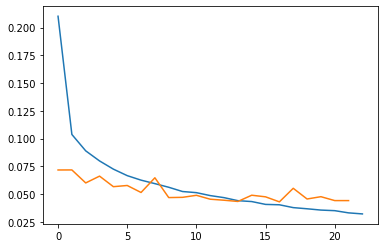

In [85]:
plt.plot(losses_epochs_train)
plt.plot(losses_epochs_valid)

### Testing 

In [91]:
inputs_test, predval_test = test_data
inputs_test = inputs_test[0]

In [92]:
outputs_test = model(inputs_test.transpose(1,2))

In [93]:
test_loss = loss(outputs_test.reshape(-1), predval_test)

In [94]:
test_loss

tensor(0.0563, grad_fn=<MseLossBackward>)

MSE_LOSS = 0.0563

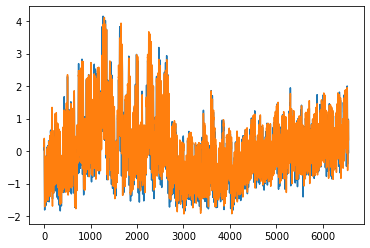

In [95]:
plt.plot(predval_test)
plt.plot(outputs_test.reshape(-1).data)

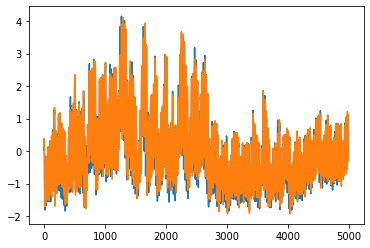

In [96]:
plt.plot(predval_test[:5000])
plt.plot(outputs_test.reshape(-1).data[:5000])

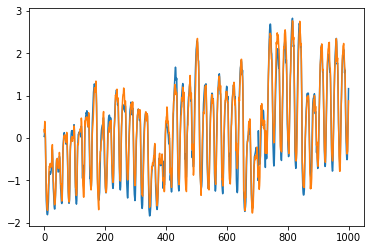

In [97]:
plt.plot(predval_test[:1000])
plt.plot(outputs_test.reshape(-1).data[:1000])

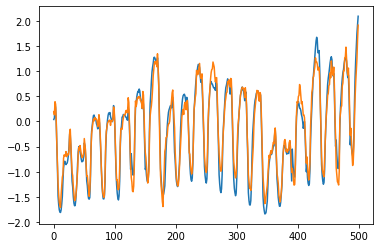

In [98]:
plt.plot(predval_test[:500])
plt.plot(outputs_test.reshape(-1).data[:500])

In [99]:
now = 0
def next_graph():
    print(now)
    plt.plot(predval_test[now:now + 200])
    plt.plot(outputs_test.reshape(-1).data[now:now + 200])
    return(now + 200)

def prev_graph():
    print(now-200)
    plt.plot(predval_test[now - 200:now ])
    plt.plot(outputs_test.reshape(-1).data[now-200:now])
    return(now - 200)

2200


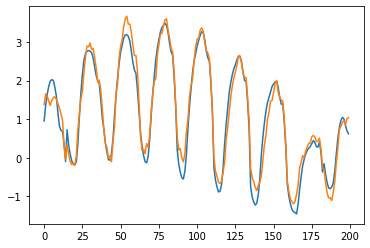

In [111]:
now = next_graph()

19000


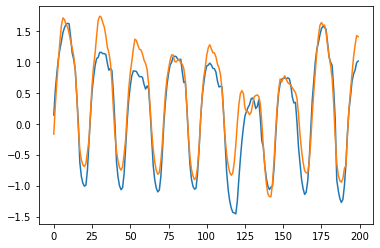

In [429]:
now = prev_graph()